# 3D Cloud TOA Notebook
This notebook allows the user to perform inference on cloud content in ABI data. 

ABI data is loaded from disk, and a 128x128 chip is created from user-defined lat, lon input. Users can either input one single lat/lon pair, which will be the center of the generated image, or 2 "endpoints". In the case of endpoints, the center of the image will be the midpoint of both inputs. *See the "user-defined values" cell for example usage.*

The generated image (128x128 pixel "chip") will then be generated, processed, and be fed into the model. Finally, the image and the transect used will be plotted alongside the model output, a predicted cloud mask at varying altitudes.  

## Installs/imports

In [1]:
# !pip install pyhdf netcdf4 h5netcdf

In [23]:
import pyhdf
from pyhdf.SD import SD, SDC

import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import sys 
import torch
from matplotlib import colormaps

sys.path.append('pytorch-caney')
from pytorch_caney.config import _C, _update_config_from_file
from pytorch_caney.data.datasets.abi_3dcloud_dataset import ABI3DCloudsDataset
from threedcloud_svtoa import (ABITransform, load_pretrained_model, FCN, 
                              MinMaxEmissiveScaleReflectance, reverse_transform)

## User-defined values

In [3]:
# Time of day, year, day of year
t = 15 # 15, 16, 17, 19
YYYY = "2019"
DDD = "270"

# Root directory for ABI data
ROOT = "/explore/nobackup/people/jli30/data/abi_dg/abi/"

def midpoint (p1, p2):
    return (p1[0]+p2[0])/2, (p1[1]+p2[1])/2

# ----------------------------------------
# Input 2 endpoints p1, p2 or a single point to generate chip 
# (single point is center of chip). Generated endpoint must be
# within the bounds: 
#    lat: [-39.5, 39.5]
#    lon: [-122.5, -26.25]
# ----------------------------------------

p1 = (39.5, -26)
p2 = (39.5, -27)
lat, lon = midpoint(p1, p2)
print(f'lat, lon midpoint used to generate chip: {lat, lon}')

lat, lon midpoint used to generate chip: (39.5, -26.5)


## Read, process ABI data

In [4]:
# load ABI data into a dict for later use
def load_abi(abi_path):
    ds = xr.open_dataset(abi_path)
    
    BOUND_SIZE = 1600
    LENGTH = 10848
    
    abi_dict = {
        'BOUND_SIZE': BOUND_SIZE, 
        'LENGTH': LENGTH,
        'abiLong': ds['Longitude'].to_numpy(),
        'abiLat': ds['Latitude'].to_numpy(),
    }
    
    # bounds of ABI lat/lon   
    abiLongB = abi_dict['abiLong'][
            BOUND_SIZE:LENGTH-BOUND_SIZE, 
            BOUND_SIZE:LENGTH-BOUND_SIZE]
    abiLatB = abi_dict['abiLat'][
            BOUND_SIZE:LENGTH-BOUND_SIZE, 
            BOUND_SIZE:LENGTH-BOUND_SIZE]
    
    # adjust NODATA values
    abiLongB[abiLongB == -999] = 10
    abiLatB[abiLatB == -999] = 10
    
    # update dict with updated bound arrays 
    abi_dict['abiLongB'] = abiLongB
    abi_dict['abiLatB'] = abiLatB
    
    # min/max values
    abi_dict['longMin'] = abiLongB.min()
    abi_dict['longMax'] = abiLongB.max()
    abi_dict['latMin'] = abiLatB.min()
    abi_dict['latMax'] = abiLatB.max()
    
    # create lat/lon slices in ABI data
    latSlice = abi_dict['abiLat'][:, 5424]
    latSlice = latSlice[18:-18]
    latSlice = latSlice[::-1]
    abi_dict['latSlice'] = latSlice
    
    longSlice = abi_dict['abiLong'][5424, :]
    longSlice = longSlice[18:-18]
    abi_dict['longSlice'] = longSlice
    
    return abi_dict

In [5]:
abi_path = "/explore/nobackup/people/jgong/ABI_EAST_GEO_TOPO_LOMSK.nc"
abi_dict = load_abi(abi_path)

In [6]:
GATHERED_ABI_FILES = {}
COLLECTED_ABI_DATA = {}

## Functions to load ABI, create chip

#### Function to load ABI data

In [7]:
def gather_files(YYYY, DDD, HH, ROOT):
    ABI_ = {
        "ROOT_PATH": None,

        "YYYY": None,
        "DDD": None,
        "HH": None,

        "00": [],
        "10": [],
        "15": [],
        "20": [],
        "30": [],
        "40": [],
        "45": [],
        "50": [],

        "L200": None,
        "L210": None,
        "L220": None,
        "L230": None,
        "L240": None,
        "L250": None,

        "everyten": False,
    }

    _ABI_PATH_ = ROOT + YYYY + "/" + DDD + "/" + HH
    
    # Find in folder
    for filename in os.listdir(_ABI_PATH_):
        if ABI_["ROOT_PATH"] == None:
            ABI_["ROOT_PATH"] = _ABI_PATH_
            ABI_["YYYY"] = filename[27:31]
            ABI_["DDD"] = filename[31:34]
            ABI_["HH"] = filename[34:36]
        MM = filename[36:38]
        if MM == "10":
            ABI_["everyten"] = True
        ABI_[f"{MM}"].append(filename)
    
    return ABI_

def get_L1B_L2(abipaths, l2path, YYYY, DDD, HH, ROOT):
    
    if len(abipaths) != 16:
        raise ImportError("This hour is bad")

    # Load each ABI channel image
    CHANNELS = []

    print("Loading Data")
    
    for file in abipaths:
        ds = xr.open_dataset((ROOT + "/" + YYYY + "/" + DDD + "/" + HH + "/" + file))
        L1B = ds["Rad"].to_numpy()
        CHANNEL = int(file[19:21])
        CHANNELS.append((L1B, CHANNEL))

    # Sort channels
    CHANNELS.sort(key=lambda x: x[1])
    CHANNELS = [C[0] for C in CHANNELS]

    T = []
    
    # Resize all channels to have same shape
    for C in CHANNELS:
        S = C.shape[0] // 5424
        if S == 1:
            C = np.repeat(C, 2, axis=0)
            C = np.repeat(C, 2, axis=1)
        if S == 4:
            C = C[::2, ::2]
        T.append(C)

    CHANNELS = T

    # Create single image with all channels
    ABI = np.stack(CHANNELS, axis=2)

    return ABI

#### Function to create chip from loaded ABI data

In [8]:
def create_chip(abi_dict, t, yy, ddn, lat, lon, ABI_ROOT):
    # Assert times are within min/max    
    if np.floor(t) < 12:
        raise ValueError("Times must be between 12-23")
        
    # Assert given lat/lon pair is within min/max    
    latMin, latMax = abi_dict['latMin'], abi_dict['latMax']
    longMin, longMax = abi_dict['longMin'], abi_dict['longMax']
    
    if lat < latMin or lat > latMax or lon < longMin or lon > longMax:
        raise ValueError("Latitude and Longitude are too large or small.")
    
    # Search 1000x1000 area for best chip    
    AREA_SIZE = 1000
    
    # Retrieve our slice of ABI data from dict     
    latSlice, longSlice = abi_dict['latSlice'], abi_dict['longSlice']

    # Indices of lat/lon pair in ABI data
    lati = len(latSlice) - np.searchsorted(latSlice, lat) + 17
    loni = np.searchsorted(longSlice, lon) + 18
    
    # Retrieve ABI lat/lon values array     
    abiLat, abiLong = abi_dict['abiLat'], abi_dict['abiLong']
    
    # Calculate distance from ABI lat/lon vals from input    
    distances = np.abs(
            abiLat[lati-AREA_SIZE:lati+AREA_SIZE, 
                   loni-AREA_SIZE:loni+AREA_SIZE] - lat) + np.abs(
            abiLong[lati-AREA_SIZE:lati+AREA_SIZE, 
                    loni-AREA_SIZE:loni+AREA_SIZE] - lon)
    # Coords are min distance ABI lat/lon vals     
    coords = np.array(np.unravel_index(distances.argmin(), distances.shape))
    
    # Special case where coords are exactly twice area size - 1     
    if (coords[0] == 0 
            or coords[1] == 0 
            or coords[1] == 2*AREA_SIZE - 1 
            or coords[0] == 2*AREA_SIZE - 1):
        print("FALLBACK")
        distances = np.abs(abiLat - lat) + np.abs(abiLong - lon)
        coords = np.unravel_index(distances.argmin(), distances.shape)
    else: # general case where we start somewhere in middle
        coords[0] += lati - AREA_SIZE
        coords[1] += loni - AREA_SIZE
        
    # Retrieve our boundary constants from dict         
    BOUND_SIZE, LENGTH = abi_dict['BOUND_SIZE'], abi_dict['LENGTH']
    
    # Second bounding check for lat/lon (based on distances arr above)    
    if (coords[0] < BOUND_SIZE 
            or coords[1] < BOUND_SIZE 
            or coords[1] > LENGTH-BOUND_SIZE 
            or coords[0] > LENGTH-BOUND_SIZE):
        print(f'coords: {coords}')
        print(f'bound_size={BOUND_SIZE}')
        print(f'len-bound_size={LENGTH-BOUND_SIZE}')
        raise ValueError("Generated chip coordinates are too close to the boundary.")

    hour = np.floor(t).astype(int)

    # Gather ABI file
    DATA = GATHERED_ABI_FILES.get(f'{yy}-{ddn}-{hour}')
    if DATA is None:
        DATA = gather_files(str(yy), str(ddn), str(hour), ABI_ROOT)
        GATHERED_ABI_FILES[f'{yy}-{ddn}-{hour}'] = DATA

    # Find the closest minute
    if DATA["everyten"]:
        minutes = np.round((t - np.floor(t)) * 6).astype(int) * 10
    else:
        minutes = np.round((t - np.floor(t)) * 4).astype(int) * 15

    # Shift hour/minute values, except if it would change the day
    if minutes == 60:
        if hour != 23:
            hour += 1
            minutes = 0
        else:
            if DATA["everyten"]:
                minutes = 50
            else:
                minutes = 45

    # Process minutes string            
    minutes = str(minutes)
    if minutes == "0":
        minutes = "00"

    # Collect ABI data from file    
    ABI = COLLECTED_ABI_DATA.get(f'{yy}-{ddn}-{hour}-{minutes}')
    if ABI is None:
        ABI = get_L1B_L2(DATA[minutes], DATA["L200"], DATA["YYYY"], DATA["DDD"], DATA["HH"], ABI_ROOT)
        COLLECTED_ABI_DATA[f'{yy}-{ddn}-{hour}-{minutes}'] = ABI

    # Create 128x128 chip to return
    chip = ABI[coords[0]-64:coords[0]+64, coords[1]-64:coords[1]+64, :]
    
    # Rearrange chip's bands
    translation = [1, 2, 0, 4, 5, 6, 3, 8, 9, 10, 11, 13, 14, 15]
    chip = chip[..., translation]
    
    transform = ABITransform(img_size=128) 
    chip = transform(chip)
    chip = np.expand_dims(chip, axis=0)

    # Chip needs to be a tensor on cuda device for model inference
    chip = torch.from_numpy(chip).cuda();
    
    return chip, coords

## Create and process chip

In [9]:
chip, coords = create_chip(abi_dict, t, YYYY, DDD, lat, lon, ROOT)

FALLBACK
Loading Data


## Load model

#### Filenames and directories

In [10]:
model_dir = './3B_26M/'
config_filename = model_dir + 'mim_pretrain_swinv2_satvision_giant_128_window08_patch8_onecycle_100ep.yaml'
model_filename = model_dir + 'mp_rank_00_model_states.pt'

#### Load config file

Required for loading pretrained SatVision model. 

In [11]:
config = _C.clone()
_update_config_from_file(config, config_filename)
config.defrost()
config.MODEL.RESUME = model_filename
config.OUTPUT = '.'
config.freeze()

=> merge config from ./3B_26M/mim_pretrain_swinv2_satvision_giant_128_window08_patch8_onecycle_100ep.yaml


#### Build base model

This will be our base transformer model with SatVision embeddings. This model has not been trained on cloud masking, but will be matched to this task below. 

In [12]:
OUTPUT_CHANNELS = 1
freeze_encoder = False
pretrained_model = load_pretrained_model(config)
model = FCN(swin_encoder=pretrained_model.encoder, num_output_channels=OUTPUT_CHANNELS, freeze_encoder=freeze_encoder)
model.eval()
model.cuda();

/home/ajkerr1/.local/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


#### Load checkpoint for 3D cloud task

Model that has been built from config is the general SatVision model, this model will be untrained on the cloud masking task. By loading this checkpoint, we are allowing the model to specialize to this downstream task.

In [13]:
checkpoint_filename = os.path.join(
    '/explore/nobackup/projects/ilab/projects',
    'SatVision/SatVision-TOA/3DClouds/models/3DCLOUD-TASK',
    'svtoa-checkpoints/3B_26M/epoch=41-val_iou=0.54145294.ckpt.ckpt',
    'checkpoint/mp_rank_00_model_states.pt')
checkpoint = torch.load(checkpoint_filename)
checkpoint_model = checkpoint['module']
checkpoint_model = {k.replace('model.', ''): v for k, v in checkpoint_model.items() if k.startswith('model')}
model.load_state_dict(checkpoint_model, strict=False)

<All keys matched successfully>

In [14]:
checkpoint_filename

'/explore/nobackup/projects/ilab/projects/SatVision/SatVision-TOA/3DClouds/models/3DCLOUD-TASK/svtoa-checkpoints/3B_26M/epoch=41-val_iou=0.54145294.ckpt.ckpt/checkpoint/mp_rank_00_model_states.pt'

## Perform Model Inference

In [15]:
logit = model(chip)
pred = torch.sigmoid(logit)

/home/ajkerr1/.local/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


## Process inputs, predictions for viz

#### User-defined variables for viz

In [16]:
# Used for input, transforms RGB bands
red_coi = 0.9 
green_coi = 0.45
blue_coi = 0.65
rgb_index = [1, 2, 0]

# Used for plot size
num_predictions = 1

#### Input processing functions

In [17]:
def pb_minmax_norm(img):
    normalized = np.zeros_like(img, dtype=float)

    for i in range(3):
        band = img[:,:,i]
        min_val = band.min()
        max_val = band.max()
        normalized[:,:,i] = (band - min_val) / (max_val - min_val)

    return normalized

#### Process inputs

In [18]:
chip = chip.cpu().numpy().squeeze()

image = reverse_transform(chip)

rgb_image = np.stack((image[rgb_index[0], :, :]*red_coi,
                            image[rgb_index[1], :, :]*green_coi,
                            image[rgb_index[2], :, :]*blue_coi),
                            axis=-1)
rgb_image = pb_minmax_norm(rgb_image*1.1)

#### Process predictions

In [19]:
# Change prediction to binary mask, correct the shape for plotting
pred_binary = (pred > 0.5).float()
pred_binary = pred_binary.cpu().numpy()
pred_binary = np.rot90(pred_binary, k=1, axes=(2, 3)).squeeze()
print(pred_binary.shape)

(40, 91)


## Plot inference, input

#### Trying to figure out x axis ticks for bin mask

In [20]:
# finding coords for tick labels
print(abi_dict['abiLat'].shape)
# this is the "middle" of our image
# our indices go from (coords - 64) to (coords + 64)
print(abi_dict['abiLat'][coord[0]][coord[1]])

x_values = np.linspace(128/2+9, 128/2-9, 100)  
y_values = np.linspace(0, 128-1, 100)
# for j in range(len(x_values)-1):
#     x_vals = [round(float(x), 2) for x in [x_values[j], x_values[j+1]]]
#     y_vals = [round(float(y), 2) for y in [y_values[j], y_values[j+1]]]
#     print(x_vals, y_vals)

(10848, 10848)


NameError: name 'coord' is not defined

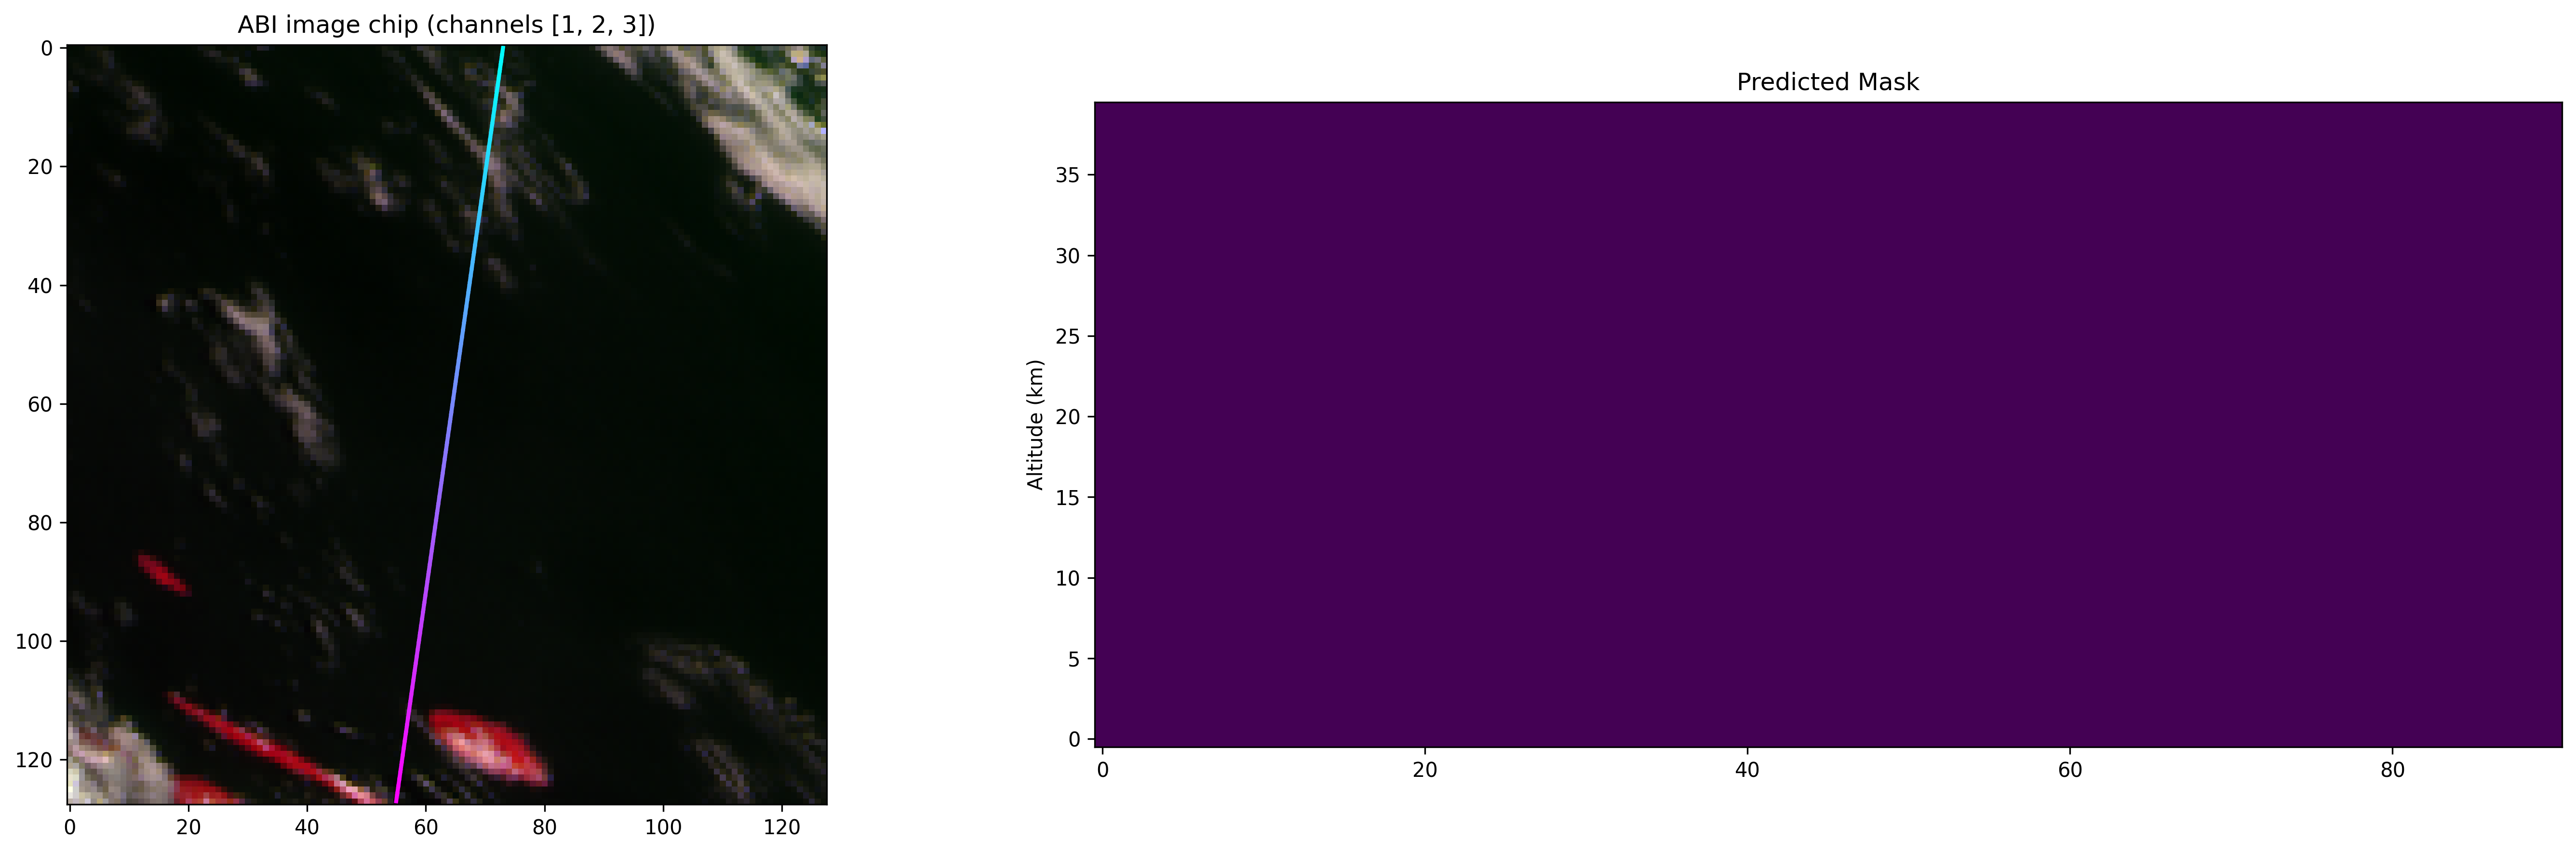

In [21]:
fig, axes = plt.subplots(num_predictions, 2, figsize=(20, 6 * num_predictions), dpi=300)

# Plot ABI input image as base layer
axes[0].imshow(rgb_image)

# Values to plot for transect
#   x_values: 100 points, transect is midway across the 128x128 chip
#   y_values: bottom to top of 128x128 chip, also 100 values
x_values = np.linspace(128/2+9, 128/2-9, 100)  
y_values = np.linspace(0, 128-1, 100)

# Transect colormap
cmap = colormaps['cool']
colors = cmap(np.linspace(0, 1, len(x_values)))  # Map positions along the line to the colormap

# Plot the transect with gradent color values
for j in range(len(x_values)-1):
    axes[0].plot(
        [x_values[j], x_values[j+1]], 
        [y_values[j], y_values[j+1]], 
        color=colors[j], lw=2)

axes[0].set_title(f'ABI image chip (channels [1, 2, 3])')
axes[0].axis('on')

# Plot model cloud mask prediction
axes[1].matshow(pred_binary, cmap='viridis')  # First channel contains the binary mask
axes[1].set_title(f'Predicted Mask')
axes[1].axis('on')
axes[1].invert_yaxis()
axes[1].set_ylabel('Altitude (km)')
axes[1].xaxis.set_ticks_position('bottom')

plt.tight_layout()
plt.show()